In [28]:
%pylab inline
import pysd
import pandas as pd
import scipy.optimize

Populating the interactive namespace from numpy and matplotlib


1403 conversations


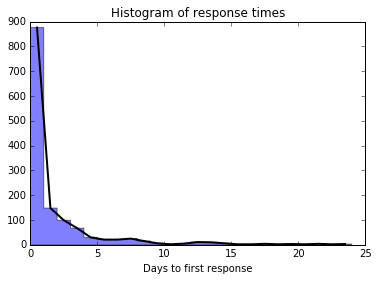

In [29]:
response_times = pd.read_csv('../../data/Emails/days_to_join_conversation.csv', names=['id','Days'], index_col='id')
num_conversations = len(response_times)
print num_conversations, 'conversations'

counts, edges, _ = plt.hist(response_times['Days'], bins=range(25), histtype='stepfilled', alpha=.5)
data = pd.Series(data=counts, 
                 index=1.*(edges[:-1]+edges[1:])/2) #take the average location in the bin

data.plot(linewidth=2, color='k', xlim=(0,25), 
          title='Histogram of response times');
plt.xlabel('Days to first response');

(0, 20)

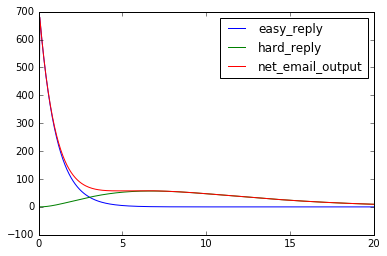

In [3]:
model = pysd.read_vensim('../../models/Emails/Emails_in_2_fixed_categories.mdl')
params = {'total_emails':num_conversations,
          'easy_fraction':.5,
          'easy_reply_time':1,
          'hard_reply_time':10}

model.run(params,
          return_columns=['net_email_output', 'easy_reply', 'hard_reply']).plot()
plt.xlim(0,20)

In [4]:
param_names = ['easy_fraction', 'easy_reply_time', 'hard_reply_time']

def error(param_list, data, num_conversations):
    params = dict(zip(param_names, param_list))
    params['total_emails'] = num_conversations
    
    #run the model with the new parameters, returning the info we're interested in
    result = model.run(params=params,
                       return_columns=['net_email_output'],
                       return_timestamps=list(data.index.values))
    
    #the sum of the squared errors
    sse = sum((result['net_email_output'] - data)**2)
    return sse

error([.5, .5, 20], data, num_conversations)

53972.16788508601

In [26]:
params = {'easy_fraction':.42,
          'easy_reply_time':1.1,
          'hard_reply_time':21.5}

bounds = {'easy_fraction':[0.001,.999],
          'easy_reply_time':[0.001,80],
          'hard_reply_time':[.001,80]}

res = scipy.optimize.minimize(error, [params[key] for key in param_names],
                              args=(data, num_conversations),
                              method='SLSQP',#'L-BFGS-B', #'SLSQP', #'TNC'
                              bounds=[bounds[key] for key in param_names])
res

  status: 0
 success: True
    njev: 15
    nfev: 156
     fun: 5461.801142358961
       x: array([  0.41743885,   1.13937249,  21.50988056])
 message: 'Optimization terminated successfully.'
     jac: array([  3.52998729e+04,  -8.33129883e-02,   2.03154985e+04,
         0.00000000e+00])
     nit: 15

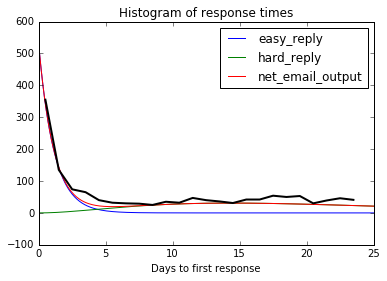

In [27]:
params=dict(zip(param_names, res['x']))
params['total_emails'] = num_conversations

model.run(params,
          return_columns=['net_email_output', 'easy_reply', 'hard_reply']).plot()

data.plot(linewidth=2, color='k', xlim=(0,25), 
          title='Histogram of response times');
plt.xlabel('Days to first response');